In [7]:
import os
import pandas as pd
import numpy as np
import seasonal
import seaborn as sns
import matplotlib.pyplot as plt
 
from ggplot import *
from scipy.stats import gmean

# Seaborn Style
sns.set(style="whitegrid", color_codes=True)

#Fix plots inline for notebook
%matplotlib inline

# Data Location within CC DS
data_location = os.path.join("..","data","external")


#######################################################
# Helpful Functions I may need

def getFiscalYear(dt):
    year = dt.year
    if dt.month>6: year += 1
    return year



#######################################################
# Create Lists of Columns for Subsetting Data for Analysis
# Create Mapping of Column Names for Cleanliness
#


compset_oar_list = ['Date',
                   'Region',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

compset_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                    }


m_cnty_oar_list = ['Year',
                   'Month',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

m_cnty_oar_mapping = {
    
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                }



region_mapping = { 
                    'Santa Barbara/Santa Maria, CA':'Santa Barbara County, CA',
                   'San Jose/Santa Cruz, CA':'San Jose-Santa Cruz, CA',
                   'Napa Valley, CA':'Napa County, CA',
                 }


region_exclude = ['Long Beach/Torrance']


transient_regions = ['Sonoma County, CA',
                     'Monterey County, CA',
                     'City of Monterey, CA',
                     'Napa County, CA',
                     'Santa Barbara County, CA']


group_regions = ['Napa County, CA',
                 'San Diego, CA',
                 'San Francisco/San Mateo, CA',
                 'Monterey County, CA',
                 'City of Monterey, CA',
                 'Santa Barbara County, CA']


region_colors = {'Sonoma County, CA':'Gray',
                     'Monterey County, CA':'Orange',
                     'City of Monterey, CA':'Orange',
                     'San Jose-Santa Cruz, CA':'Gray',
                     'Napa County, CA':'Gray',
                     'Santa Barbara County, CA':'Gray'}



# Read in Monterey County XLS
#
# Documentation for Monterey County XLS goes here...
file_path = os.path.join(data_location, "Monterey-County-City-STR-ALL.xlsx")
m_cnty = pd.read_excel(file_path, sheetname = "County of Monterey 05-16 Seg")
m_city = pd.read_excel(file_path, sheetname = "City of Monterey 13-16 Seg")

# Read in Compset data
file_path = os.path.join(data_location, "Comp-Set-STR-ALL.xlsx")
compset_hm = pd.read_excel(file_path, sheetname = "Comp-Set OCC-ADR-RevPARv2")

# Read in Budget data
file_path = os.path.join(data_location, "TID_BUDGET.xlsx")
budget = pd.read_excel(file_path, sheetname = "income")

#Helper Data to expand number of years so they are even for excel viz
file_path = os.path.join(data_location, "Region-Years.xlsx")
region_years = pd.read_excel(file_path, sheetname = "Regions")


In [8]:
###################################################
# Process city of monterey
m_city_v1 = m_city[m_cnty_oar_list]
m_city_v2 = m_city_v1.rename(columns=m_cnty_oar_mapping)

m_city_v2['Month'] = m_city_v2['Month'].apply(str)
m_city_v2['Year'] = m_city_v2['Year'].apply(str)
m_city_v2['Date'] = m_city_v2['Year'] + "-" + m_city['Month']
m_city_v2['Date'] = pd.to_datetime(m_city_v2['Date'], format = "%Y-%b")
m_city_v2['Month'] = m_city_v2['Date'].apply(lambda x: x.month)

m_city_v2['Region'] = 'City of Monterey, CA'


###################################################
# Process monterey_county
m_cnty_v1 = m_cnty[m_cnty_oar_list]
m_cnty_v2 = m_cnty_v1.rename(columns=m_cnty_oar_mapping)


m_cnty_v2['Month'] = m_cnty_v2['Month'].apply(str)
m_cnty_v2['Year'] = m_cnty_v2['Year'].apply(str)
m_cnty_v2['Date'] = m_cnty_v2['Year'] + "-" + m_cnty['Month']
m_cnty_v2['Date'] = pd.to_datetime(m_cnty_v2['Date'], format = "%Y-%b")
m_cnty_v2['Month'] = m_cnty_v2['Date'].apply(lambda x: x.month)

m_cnty_v2['Region'] = 'Monterey County, CA'

###################################################
# Process compset data
compset_hm_v1 = compset_hm = compset_hm[compset_oar_list]
compset_hm_v2 = compset_hm_v1.rename(columns=compset_oar_mapping)

#Date & Time Manipulation
compset_hm_v2['Date'] = pd.to_datetime(compset_hm_v2['Date'])
compset_hm_v2['Month'] = compset_hm_v2['Date'].apply(lambda x: str(x.month))
compset_hm_v2['Year'] = compset_hm_v2['Date'].apply(lambda x: str(x.year))


#String Manipulation
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('+','')



In [9]:
###############################################
# Combine datasets for Hotel Metrics 
tot_set = compset_hm_v2.append(m_cnty_v2)
tot_set = tot_set.append(m_city_v2)

# Sort before Calculations (Do I need to do this?)
tot_set = tot_set[(tot_set['Date'] < '2016-07-01') & (tot_set['Date'] > '2010-06-01')]
tot_set = tot_set.sort_values(by=['Date'], ascending = True)
tot_set = tot_set.round(2)
tot_set = tot_set.reset_index()

#This is an IMPORTANT STEP-HERE WE APPLY OUR FISCAL YEAR (Jun-Jul) to the YEAR variable.
# Is this best practices? I don't think so... not sure. need training.
tot_set['Year'] = tot_set['Date'].apply(getFiscalYear)


#String Manipulation
tot_set = tot_set.replace({'Region':region_mapping})
tot_set['Month'] = tot_set['Month'].apply(str)

# Drop Duplicates
tot_set = tot_set.drop_duplicates(subset=['Region','Year','Month'])

# Regions we want to keep
tot_set = tot_set[~(tot_set['Region'].isin(region_exclude))]

# Include datasets
tot_set = pd.merge(tot_set, region_years, on = ['Region','Year'], how = 'right')

#tot_set_v2[tot_set_v2['Region'] == 'Laguna Beach, CA']

In [10]:
def wavg(df):
    #print df
    value = df.iloc[:,0].dropna()
    print value
    weights = df.iloc[:,1].dropna()
    weights = weights.apply(int)
    weights = tuple(weights)
    print weights
    series = pd.Series()
    subdf = value.dropna()

    series['np.mean'] = np.mean(subdf)
    #series['np.average (no weights)'] = np.average(subdf)
    #series['np.average (weighted)'] = np.average(subdf, weights)
    #series['np.ma.average (weighted)'] = np.ma.average(subdf, weights) 

    return series



##############################################
# Calculate metrics, in this case, simple growth MOM & YOY
# May consider YTD


#Average Daily Rate  MOM & YOY & Annual changes

tot_set['ADR_GRP_MOM'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(1)
tot_set['ADR_TRANS_MOM'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(1)
tot_set['ADR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(1)

tot_set['ADR_GRP_YOY'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(12)
tot_set['ADR_TRANS_YOY'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(12)
tot_set['ADR_TOTAL_YOY'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(12)

#Occupancy MOM & YOY & Annual
tot_set['OCC_GRP_MOM'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(1)
tot_set['OCC_TRANS_MOM'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(1)
tot_set['OCC_TOTAL_MOM'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(1)

tot_set['OCC_GRP_YOY'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(12)
tot_set['OCC_TRANS_YOY'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(12)
tot_set['OCC_TOTAL_YOY'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(12)


#RevPar MOM & YOY & Annual
tot_set['RevPAR_GRP_MOM'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(1)
tot_set['RevPAR_TRANS_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(1)
tot_set['RevPAR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(1)

tot_set['RevPAR_GRP_YOY'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(12)
tot_set['RevPAR_TRANS_YOY'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(12)
tot_set['RevPAR_TOTAL_YOY'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(12)


In [11]:
##################################################
# Let's visualize this data for output to Tammy & Rob
# 
agg_set = pd.DataFrame()

#########################################################################################
# Now that metrics are calculated lets create the aggregated set for Annual Averages and Rankings

agg_set['ADR_GRP_ANN'] =     tot_set.groupby(['Region','Year'])['ADR_GRP_YOY'].mean()
agg_set['ADR_TRANS_ANN'] =   tot_set.groupby(['Region','Year'])['ADR_TRANS_YOY'].mean()
agg_set['ADR_TOTAL_ANN'] =   tot_set.groupby(['Region','Year'])['ADR_TOTAL_YOY'].mean()

agg_set['OCC_GRP_ANN'] =     tot_set.groupby(['Region','Year'])['OCC_GRP_YOY'].mean()
agg_set['OCC_TRANS_ANN'] =   tot_set.groupby(['Region','Year'])['OCC_TRANS_YOY',].mean()
agg_set['OCC_TOTAL_ANN'] =   tot_set.groupby(['Region','Year'])['OCC_TOTAL_YOY'].mean()

agg_set['RevPAR_GRP_ANN'] =     tot_set.groupby(['Region','Year'])[['Date','RevPAR_GRP_YOY','Region']].mean()
agg_set['RevPAR_TRANS_ANN'] =   tot_set.groupby(['Region','Year'])[['Date','RevPAR_TRANS_YOY','Region']].mean()
agg_set['RevPAR_TOTAL_ANN'] =   tot_set.groupby(['Region','Year'])[['Date','RevPAR_TOTAL_YOY','Region']].mean()

# Actuals Averaged
agg_set['ADR_GRP_AVG'] =     tot_set.groupby(['Region','Year'])['ADR_GRP'].mean()
agg_set['ADR_TRANS_AVG'] =   tot_set.groupby(['Region','Year'])['ADR_TRANS'].mean()
agg_set['ADR_TOTAL_AVG'] =   tot_set.groupby(['Region','Year'])['ADR_TOTAL'].mean()

# Actuals Averaged
agg_set['OCC_GRP_AVG'] =     tot_set.groupby(['Region','Year'])['OCC_GRP'].mean()
agg_set['OCC_TRANS_AVG'] =   tot_set.groupby(['Region','Year'])['OCC_TRANS'].mean()
agg_set['OCC_TOTAL_AVG'] =   tot_set.groupby(['Region','Year'])['OCC_TOTAL'].mean()

#Actuals Averaged
agg_set['RevPAR_GRP_AVG'] =     tot_set.groupby(['Region','Year'])['RevPAR_GRP'].mean()
agg_set['RevPAR_TRANS_AVG'] =   tot_set.groupby(['Region','Year'])['RevPAR_TRANS'].mean()
agg_set['RevPAR_TOTAL_AVG'] =   tot_set.groupby(['Region','Year'])['RevPAR_TOTAL'].mean()

# Calculate Rankings
agg_set = agg_set.reset_index()
agg_set['ADR_GRP_ANN_RANK'] =     agg_set.groupby(['Year'])['ADR_GRP_ANN'].rank()
agg_set['ADR_TRANS_ANN_RANK'] =   agg_set.groupby(['Year'])['ADR_TRANS_ANN'].rank()
agg_set['ADR_TOTAL_ANN_RANK'] =   agg_set.groupby(['Year'])['ADR_TOTAL_ANN'].rank()

# Calculate Rankings
agg_set['OCC_GRP_ANN_RANK'] =     agg_set.groupby(['Year'])['OCC_GRP_ANN'].rank()
agg_set['OCC_TRANS_ANN_RANK'] =   agg_set.groupby(['Year'])['OCC_TRANS_ANN'].rank()
agg_set['OCC_TOTAL_ANN_RANK'] =   agg_set.groupby(['Year'])['OCC_TOTAL_ANN'].rank()

# Calculate Rankings
agg_set['RevPAR_GRP_ANN_RANK'] =     agg_set.groupby(['Year'])['RevPAR_GRP_ANN'].rank()
agg_set['RevPAR_TRANS_ANN_RANK'] =   agg_set.groupby(['Year'])['RevPAR_TRANS_ANN'].rank()
agg_set['RevPAR_TOTAL_ANN_RANK'] =   agg_set.groupby(['Year'])['RevPAR_TOTAL_ANN'].rank()

agg_set = agg_set.reset_index()
#################
# Offhand visuals I need for analysis

# sns.factorplot(data=agg_set, x='Year', y='OCC_TOTAL_AVG',hue='Region', kind = 'bar', size = 10)
# sns.factorplot(data=agg_set, x='Year', y='OCC_TOTAL_ANN', hue = 'Region', size = 10)

# #sns.factorplot(data=agg_set, x='Year', y='OCC_GRP_AVG', hue = 'Region', kind = 'bar', size = 10)
# ax = sns.factorplot(data=agg_set, x='Year', y='OCC_GRP_ANN', hue = 'Region', size = 10)
# #sns.factorplot(data=agg_set, x='Year', y='OCC_TRANS_AVG', hue = 'Region', kind = 'bar', size = 10)
#sns.factorplot(data=agg_set, x='Year', y='OCC_TRANS_ANN', hue = 'Region', kind = 'bar', size = 10)

# #sns.factorplot(data=agg_set, x='Year', y='RevPAR_GRP_AVG', hue = 'Region', kind = 'bar', size = 10)
#sns.factorplot(data=agg_set, x='Year', y='RevPAR_GRP_ANN', hue = 'Region', kind = 'bar', size = 10)

# #sns.factorplot(data=agg_set, x='Year', y='RevPAR_TRANS_AVG', hue = 'Region', kind = 'bar', size = 10)
# sns.factorplot(data=agg_set, x='Year', y='RevPAR_TRANS_ANN', hue = 'Region', kind = 'bar', size = 10)

# #sns.factorplot(data=agg_set, x='Year', y='RevPAR_TOTAL_AVG', hue = 'Region', kind = 'bar', size = 10)
# sns.factorplot(data=agg_set, x='Year', y='RevPAR_TOTAL_ANN', hue = 'Region', kind = 'bar', size = 10)

# #sns.factorplot(data=agg_set, x='Year', y='ADR_GRP_AVG', hue = 'Region', kind = 'bar', size = 10)
# sns.factorplot(data=agg_set, x='Year', y='ADR_GRP_ANN', hue = 'Region', kind = 'bar', size = 10)

# #sns.factorplot(data=agg_set, x='Year', y='ADR_TRANS_AVG', hue = 'Region', kind = 'bar', size = 10)
# sns.factorplot(data=agg_set, x='Year', y='ADR_TOTAL_ANN', hue = 'Region', kind = 'bar', size = 10)

agg_set.to_csv("excel_visualizations.csv")


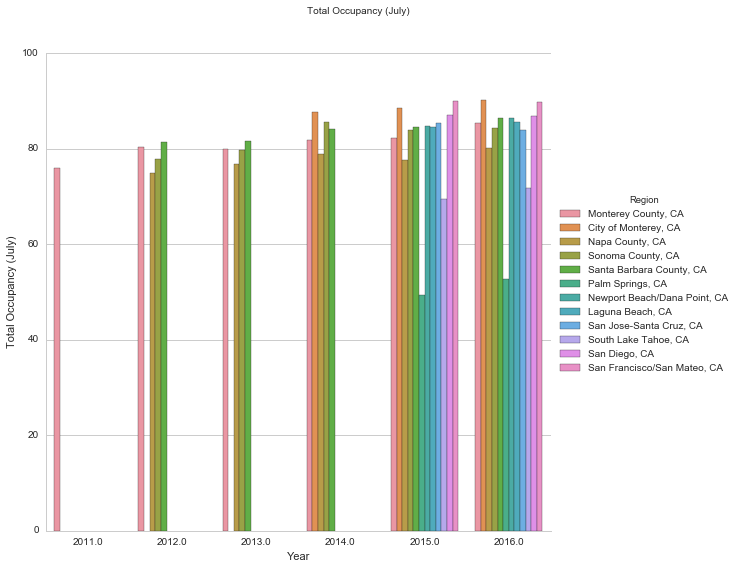

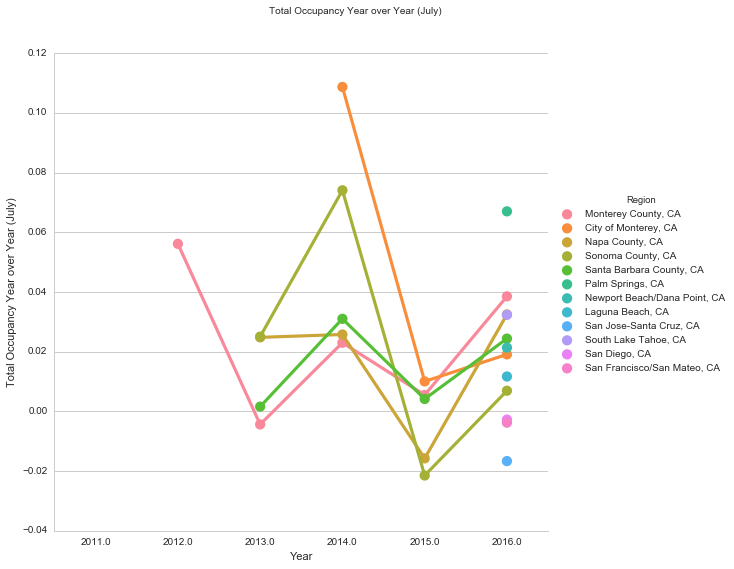

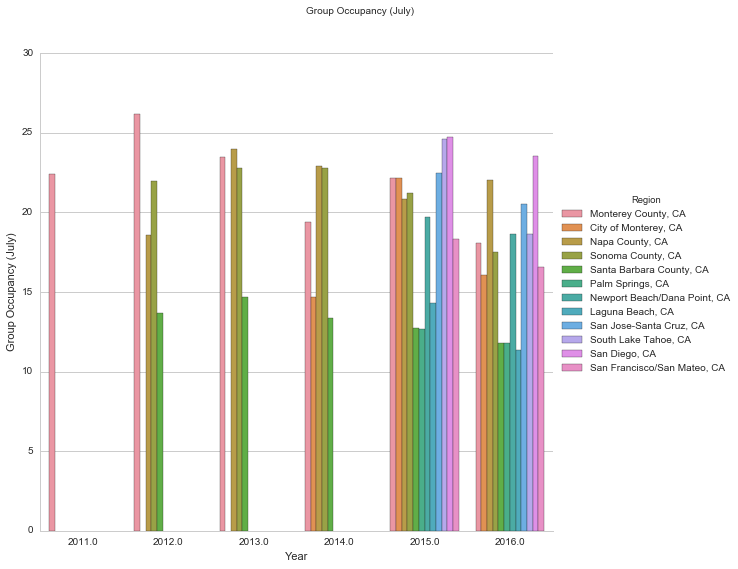

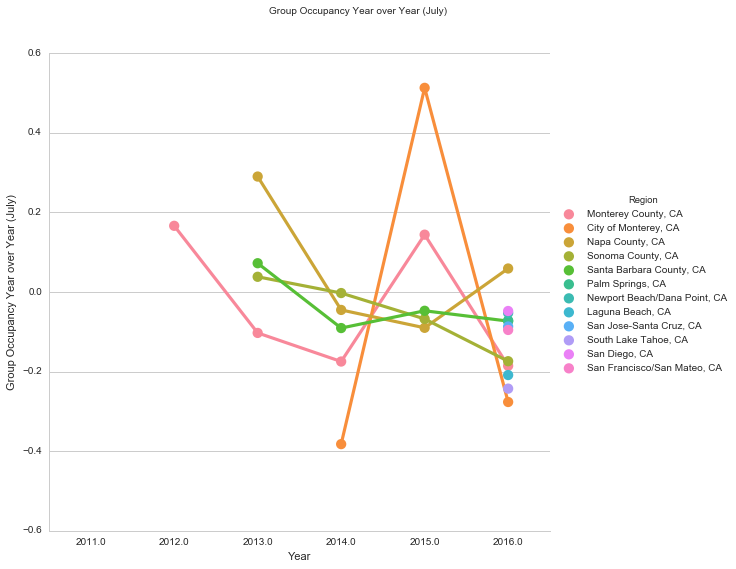

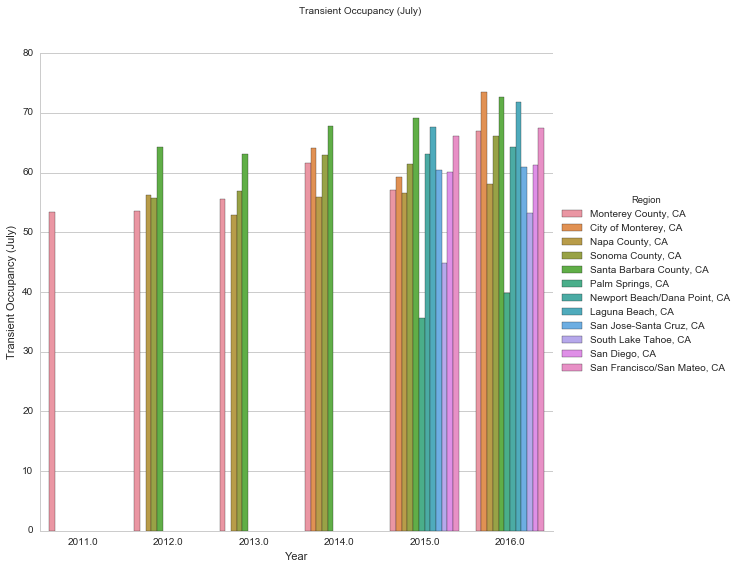

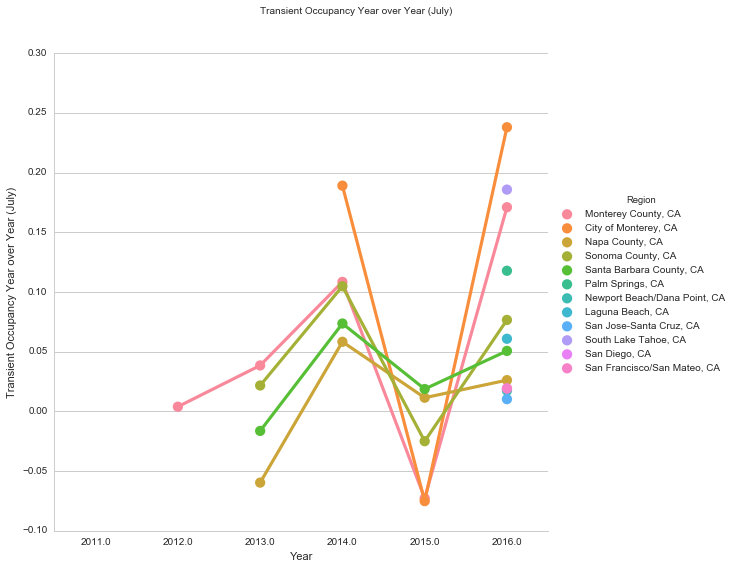

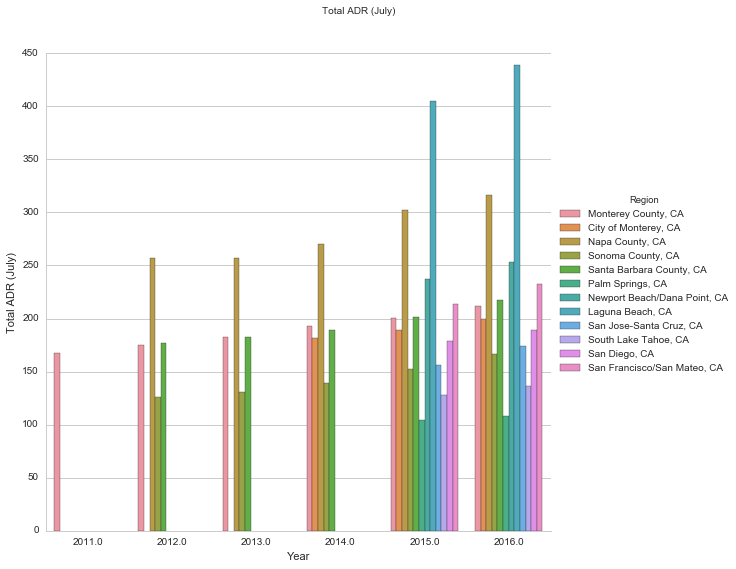

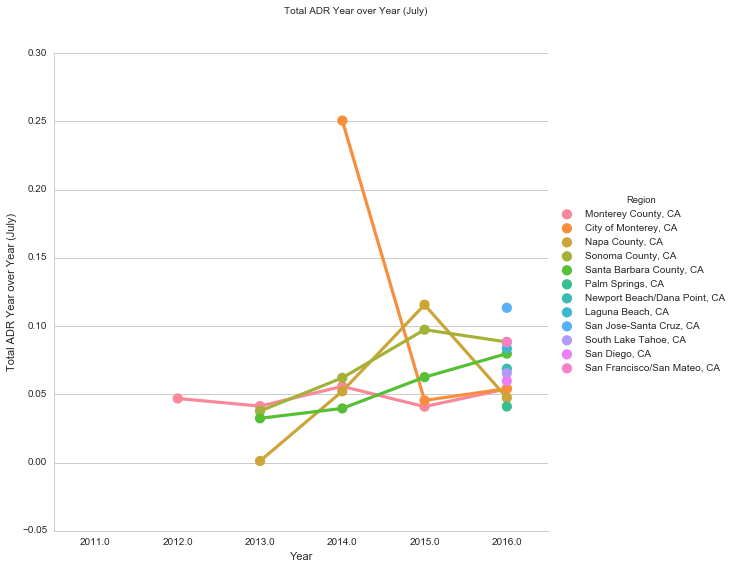

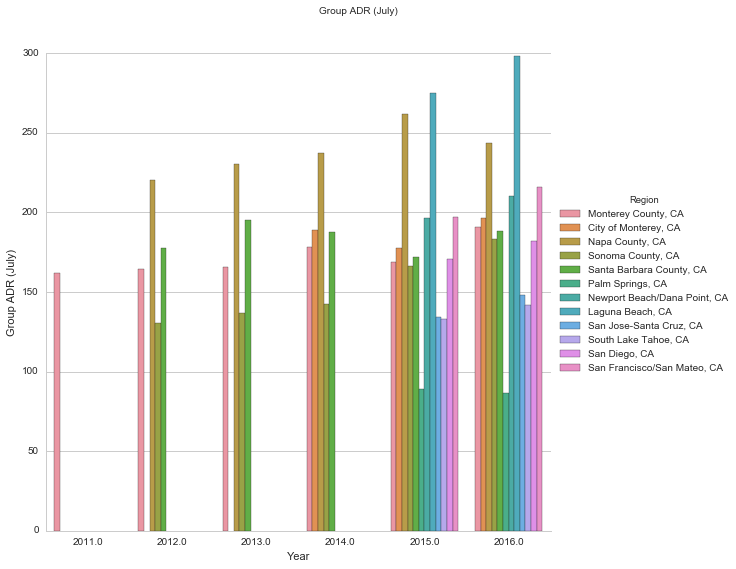

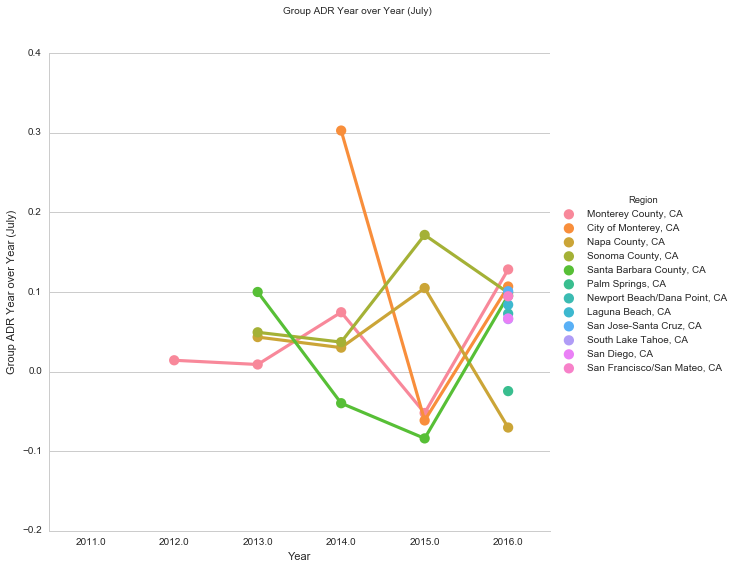

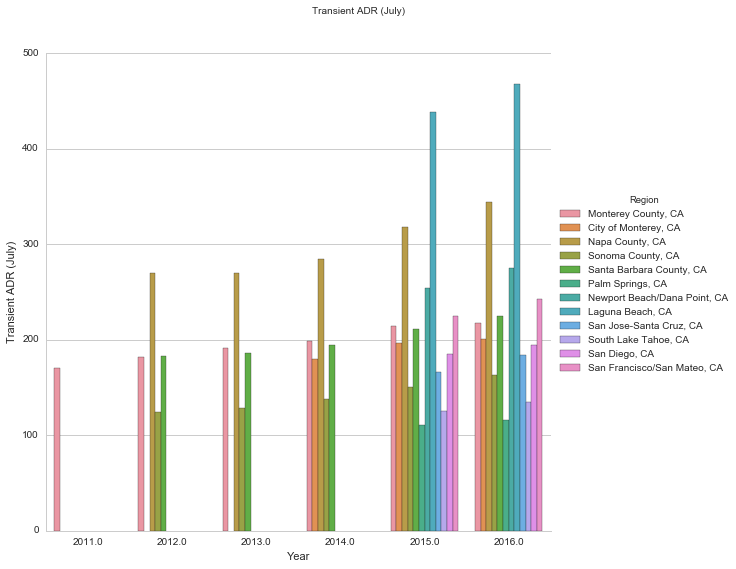

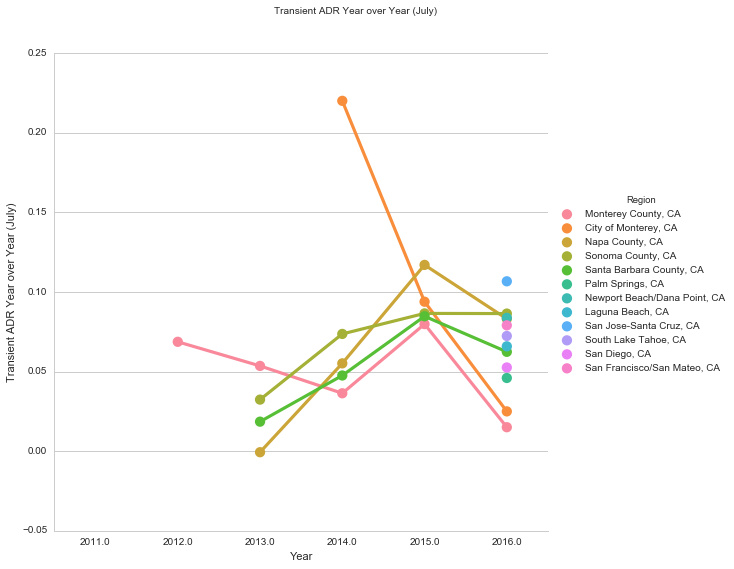

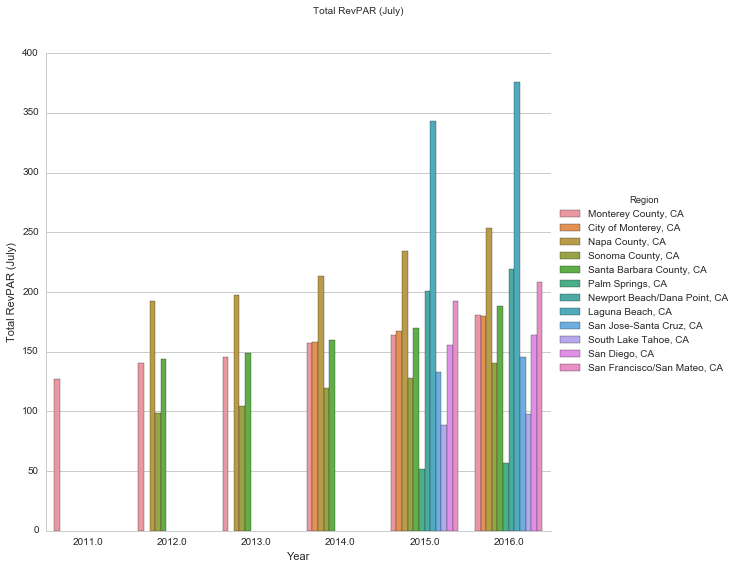

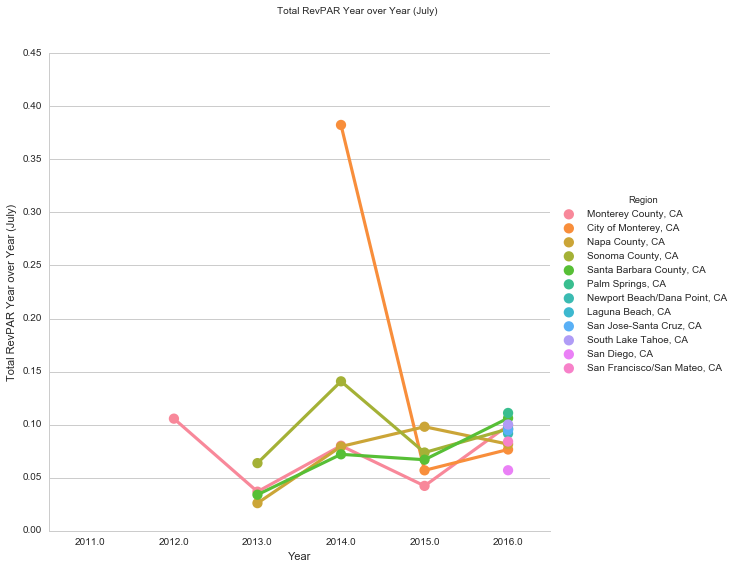

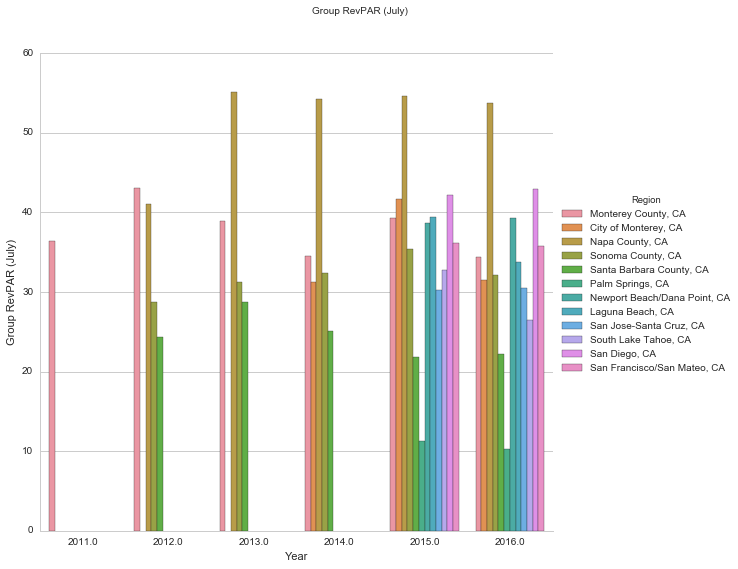

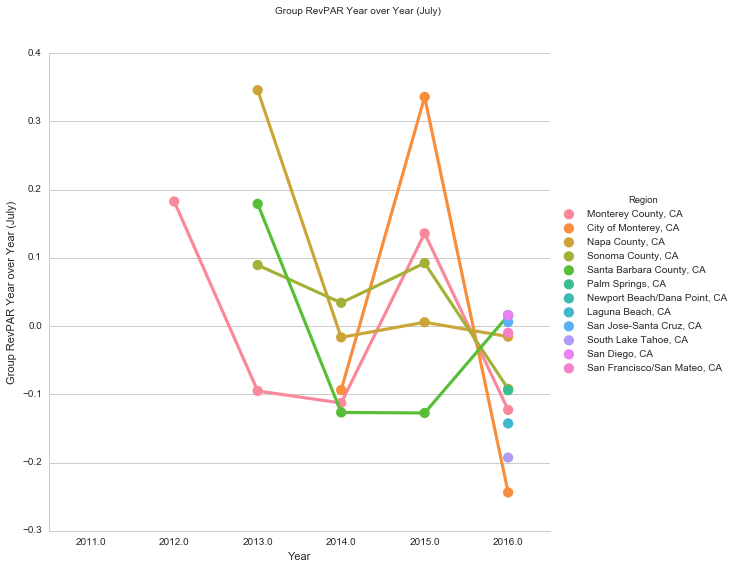

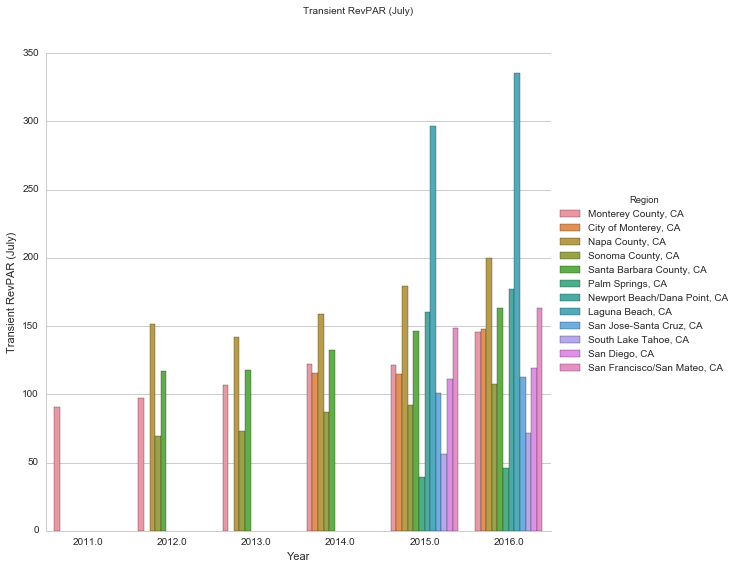

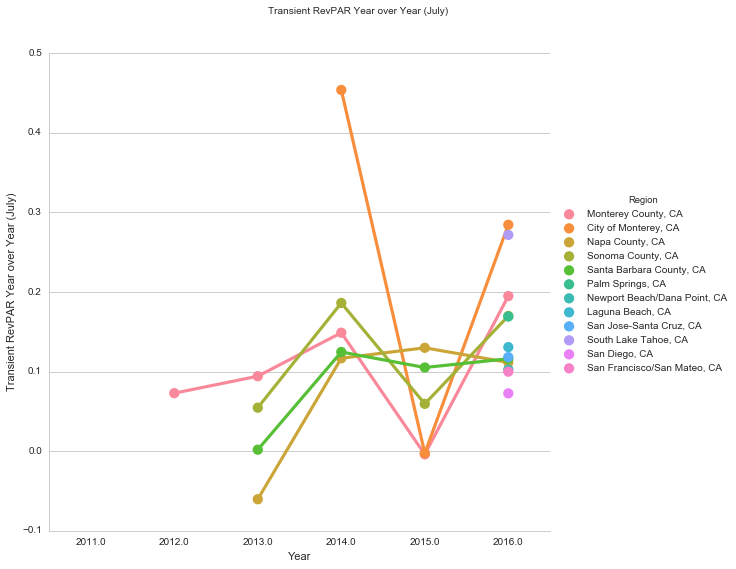

In [12]:


###################################
# Occupancy Totals & Group & Trans


## Subset data really quick for visuals

#Getting a feel for it
viz_set = tot_set
viz_set['Date'] = pd.to_datetime(viz_set['Date'])
viz_set['Month-Year'] = viz_set['Date'].apply(lambda x: str(x.month) + "-" + str(x.year))
viz_set = viz_set.sort_values(by=['Date'])

# Subset for July, our Peak Month
plot_data = viz_set[viz_set['Month'] == "7"]


#Total
ax = sns.factorplot(x='Year',y='OCC_TOTAL',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Total Occupancy (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total Occupancy (July)')
plt.savefig('Occ_Total_July.pdf')

ax = sns.factorplot(x='Year',y='OCC_TOTAL_YOY',hue='Region',data=plot_data,size=8)
ax = ax.set(ylabel='Total Occupancy Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total Occupancy Year over Year (July)')
plt.savefig('Occ_Total_YOY_July.pdf')

#Group
ax = sns.factorplot(x='Year',y='OCC_GRP',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Group Occupancy (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group Occupancy (July)')
plt.savefig('Occ_Grp_July.pdf')

ax = sns.factorplot(x="Year", y="OCC_GRP_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Group Occupancy Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group Occupancy Year over Year (July)')
plt.savefig('Occ_Grp_YOY_July.pdf')

#Trans
ax = sns.factorplot(x='Year',y='OCC_TRANS',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Transient Occupancy (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient Occupancy (July)')
plt.savefig('Occ_Trans_July.pdf')

ax = sns.factorplot(x="Year", y="OCC_TRANS_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Transient Occupancy Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient Occupancy Year over Year (July)')
plt.savefig('Occ_Trans_YOY_July.pdf')



###################################
# ADR Totals & Group & Trans

#Total
ax = sns.factorplot(x='Year',y='ADR_TOTAL',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Total ADR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total ADR (July)')
plt.savefig('ADR_Total_July.pdf')

ax = sns.factorplot(x='Year',y='ADR_TOTAL_YOY',hue='Region',data=plot_data,size=8)
ax = ax.set(ylabel='Total ADR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total ADR Year over Year (July)')
plt.savefig('ADR_Total_YOY_July.pdf')

#Group
ax = sns.factorplot(x='Year',y='ADR_GRP',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Group ADR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group ADR (July)')
plt.savefig('ADR_Grp_July.pdf')

ax = sns.factorplot(x="Year", y="ADR_GRP_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Group ADR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group ADR Year over Year (July)')
plt.savefig('ADR_Grp_YOY_July.pdf')

#Trans
ax = sns.factorplot(x='Year',y='ADR_TRANS',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Transient ADR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient ADR (July)')
plt.savefig('ADR_Trans_July.pdf')

ax = sns.factorplot(x="Year", y="ADR_TRANS_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Transient ADR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient ADR Year over Year (July)')
plt.savefig('ADR_Trans_YOY_July.pdf')


###################################
# RevPAR Totals & Group & Trans

#Total
ax = sns.factorplot(x='Year',y='RevPAR_TOTAL',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Total RevPAR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total RevPAR (July)')
plt.savefig('RevPAR_Total_July.pdf')

ax = sns.factorplot(x='Year',y='RevPAR_TOTAL_YOY',hue='Region',data=plot_data,size=8)
ax = ax.set(ylabel='Total RevPAR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total RevPAR Year over Year (July)')
plt.savefig('RevPAR_Total_YOY_July.pdf')

#Group
ax = sns.factorplot(x='Year',y='RevPAR_GRP',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Group RevPAR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group RevPAR (July)')
plt.savefig('RevPAR_Grp_July.pdf')

ax = sns.factorplot(x="Year", y="RevPAR_GRP_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Group RevPAR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group RevPAR Year over Year (July)')
plt.savefig('RevPAR_Grp_YOY_July.pdf')

#Trans
ax = sns.factorplot(x='Year',y='RevPAR_TRANS',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Transient RevPAR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient RevPAR (July)')
plt.savefig('RevPAR_Trans_July.pdf')

ax = sns.factorplot(x="Year", y="RevPAR_TRANS_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Transient RevPAR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient RevPAR Year over Year (July)')
plt.savefig('RevPAR_Trans_YOY_July.pdf')




